## 0. Import and prepair data

In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
df_data = pd.read_json("../input/resume-dataset/knowledge only.jsonl", lines = True)
df_data.drop(['id'], axis=1)

In [ ]:
import json
import re


# JSON formatting functions
def convert_data_to_spacy(JSON_FilePath):
    training_data = []
    lines=[]
    with open(JSON_FilePath, 'r') as f:
        lines = f.readlines()

    for line in lines:
        data = json.loads(line)
        text = data['data']
        data_annotations = data['label']
        training_data.append((text, {"entities" : data_annotations}))
    return training_data


def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']
        valid_entities = []
        for start, end, label in entities:
            valid_start = start
            valid_end = end
            while valid_start < len(text) and invalid_span_tokens.match(
                    text[valid_start]):
                valid_start += 1
            while valid_end > 1 and invalid_span_tokens.match(
                    text[valid_end - 1]):
                valid_end -= 1
            valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])
    return cleaned_data

In [ ]:
datas = trim_entity_spans(convert_data_to_spacy("../input/resume-dataset/knowledge only.jsonl"))
datas[0]

['bùi hoàng nhật applying fresher php gpa : 9.0 / 10 grade : excellent july 20 , 1998 male 09324350 66 nhatbui2017@gmail.com duy hải , duy xuyên , quảng nam facebook.com/nhat.hoangbui.982 / career objectives entering profession passion programming . expertise learned iviettech certificate , want become php programmer able make best use abilities . hopefully working environment company help equip experiences skills achieve goal becoming good programmer future . english skills good reading research materials hobbies music soccer movie education background university danang , university education major : infomatics teacher education . 2016 - 2020 gpa : 2.58 / 4 grade : good iviettech – professionalprogrammer training center . major : php programmer . aug 2020 - apr 2021 \uf040 technical skills php web developer - using php develop applications dont require database . - using phpmyadmin work mysql database . - developing php applications get data store data mysql database . - use mvc patte

In [ ]:
def clean_entities(training_data):
    
    clean_data = []
    for text, annotation in training_data:
        
        entities = annotation.get('entities')
        entities_copy = entities.copy()
        
        # append entity only if it is longer than its overlapping entity
        i = 0
        for entity in entities_copy:
            j = 0
            for overlapping_entity in entities_copy:
                # Skip self
                if i != j:
                    e_start, e_end, oe_start, oe_end = entity[0], entity[1], \
                    overlapping_entity[0], overlapping_entity[1]
                    # Delete any entity that overlaps, keep if longer
                    if ((e_start >= oe_start and e_start <= oe_end) \
                    or (e_end <= oe_end and e_end >= oe_start)) \
                    and ((e_end - e_start) <= (oe_end - oe_start)):
                        entities.remove(entity)
                j += 1
            i += 1
        clean_data.append((text, {'entities': entities}))
                
    return clean_data

datas = clean_entities(datas)

In [ ]:
from nltk.tokenize import WhitespaceTokenizer

df_data = pd.DataFrame(columns=["clean_content", "entities_mapped"])
entities_mapped = []
clean_content = []
for data in datas:
    entities = data[1]["entities"]
    words = []
    labels = []
    content = data[0].split()
    span_generator = WhitespaceTokenizer().span_tokenize(data[0])
    spans = [span for span in span_generator]
    for word, span in zip(content, spans):
        words.append(word)
        found = False
        for entity in sorted(entities):
            ent_start = entity[0]
            ent_end = entity[1]
            ent_label = entity[2]
            if ent_start <= span[0] <= ent_end:
                labels.append(ent_label)
                found = True
                break
        if not found:
            labels.append("O")

    entities_mapped.append(labels)
    clean_content.append(words)

df_data["entities_mapped"] = entities_mapped
df_data["clean_content"] = clean_content
df_data["clean_content"] = df_data["clean_content"].apply(lambda x: " ".join(x))

df_data

,clean_content,entities_mapped
0,bùi hoàng nhật applying fresher php gpa : 9.0 ...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,le chi binh 20/06 / 2000 08533445 03 126 nguye...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,duong van nguyen website intern contact inform...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"   education su pham ky thuat university , ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,nguyen duy bao f r e h e r p h p  06/05 / 200...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...
319,education duy tan university major : informati...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
320,education vietnam - korea university informati...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
321,nguyen thanh quang position : fresher react js...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
322,contact technical skills summary : phan ngoc b...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


<AxesSubplot:ylabel='Frequency'>

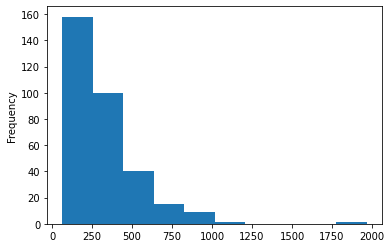

In [ ]:
df_data['entities_mapped'].apply(len).plot(kind = 'hist')

## 1. Config 

In [ ]:
import transformers

max_len = 512
train_batch_size = 16
valid_batch_size = 8
epochs = 700

base_model_path = "bert-base-uncased"
model_path = "./bert-base-uncased.bin"
last_model_path = "./bert-base-uncased-last.bin"

tokenizer = transformers.AutoTokenizer.from_pretrained(
    base_model_path,
    do_lower_case = False
)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

## 2. Create Dataset Class

In [ ]:
import torch

class EntityDataset:
    
    def __init__(self, texts, tags, enc_tag):
        self.texts = texts
        self.tags = tags
        self.enc_tag = enc_tag
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = self.texts[item]
        tags = self.tags[item]
        
        ids = []
        target_tags = []
        
        for i, s in enumerate(text):
            inputs = tokenizer.encode(
                s,
                add_special_tokens = False
            )
            # Mohamed: Mo ##ha ##med
            input_len = len(inputs)
            ids.extend(inputs)
            target_tags.extend([tags[i]] * input_len)
            
        ids = ids[: max_len - 2]
        target_tags = target_tags[: max_len - 2]

        ids = [101] + ids + [102]
        target_tags = [self.enc_tag.transform(['O'])[0]] + target_tags + [self.enc_tag.transform(['O'])[0]]

        mask = [1] * len(ids)
        token_type_ids = [0] * len(ids)

        padding_len = max_len - len(ids)

        ids = ids + ([0] * padding_len)
        mask = mask + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)
        target_tags = target_tags + ([self.enc_tag.transform(['O'])[0]] * padding_len)
        return {
            "ids": torch.tensor(ids, dtype = torch.long),
            "mask": torch.tensor(mask, dtype = torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype = torch.long),
            "target_tags": torch.tensor(target_tags, dtype = torch.long)
        }

## 3. Create train and eval methods

In [ ]:
from tqdm.notebook import tqdm
def train_fn(data_loader, model, optimizer, device, scheduler):
    
    model.train()
    final_loss = 0
    for data in tqdm(data_loader, total = len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        optimizer.zero_grad()
        loss = model(**data)[0]
        loss.backward()
        optimizer.step()
        scheduler.step()
        final_loss += loss.item()
    return final_loss / len(data_loader)

def eval_fn(data_loader, model, device):
    
    model.eval()
    final_loss = 0
    for data in tqdm(data_loader, total = len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        loss = model(**data)[0]
        final_loss += loss.item()
    return final_loss / len(data_loader)

## 4. Create model

In [ ]:
import torch.nn as nn

class EntityModel(nn.Module):
    
    def __init__(self, enc_tag):
        super(EntityModel, self).__init__()
        
        self.num_tag = len(enc_tag.classes_)
        
        self.config = transformers.AutoConfig.from_pretrained(base_model_path)
        self.config._num_labels = self.num_tag
        self.config.label2id = {k: v for k, v in zip(enc_tag.classes_, enc_tag.transform(enc_tag.classes_))}
        self.config.id2label = {k: v for k, v in zip(enc_tag.transform(enc_tag.classes_), enc_tag.classes_)}

        self.classifier = transformers.AutoModelForTokenClassification.from_config(self.config)

        
    def forward(self, ids, mask, token_type_ids, target_tags):
        output_1 = self.classifier(ids, attention_mask = mask, token_type_ids = token_type_ids, labels = target_tags)
        return output_1

## 5. Training

In [ ]:
from sklearn import preprocessing
from sklearn import model_selection


import joblib
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

def process_data(df):
  
    enc_tag = preprocessing.LabelEncoder()
    
    all_ents = df['entities_mapped'].apply(pd.Series).stack().values
    enc_tag.fit(all_ents)
    
    sentences = list(df["clean_content"].str.split())
    tag = list(df["entities_mapped"].apply(enc_tag.transform))
    
    
    return sentences, tag, enc_tag

if __name__ == "__main__":
    
    sentences, tag, enc_tag = process_data(df_data)
    meta_data = {
        "enc_tag": enc_tag
    }
    
    joblib.dump(meta_data, "meta.bin")
    
    num_tag = len(list(enc_tag.classes_))

    (
        train_sentences,
        test_sentences,
        train_tag,
        test_tag
    ) = model_selection.train_test_split(sentences, tag, random_state = 68, test_size = 0.1)
    train_dataset = EntityDataset(
        texts = train_sentences, tags = train_tag, enc_tag = enc_tag
    )

    valid_dataset = EntityDataset(
        texts = test_sentences, tags = test_tag, enc_tag = enc_tag
    )
    
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size = train_batch_size, num_workers = 4
    )
    
    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size = valid_batch_size, num_workers = 2
    )

    device = torch.device("cuda")
    model = EntityModel(enc_tag = enc_tag)
    model.to(device)
    
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.weight"]
    
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.2
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0
        }
    ]
    
    num_train_steps = int(len(train_sentences) / train_batch_size * epochs)
    optimizer = AdamW(optimizer_parameters, lr = 3e-5)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps = 2, num_training_steps = num_train_steps 
    )
    
    best_loss = np.inf
    
    for epoch in range(epochs):
        
        train_loss = train_fn(train_data_loader, model, optimizer, device, scheduler)
        test_loss = eval_fn(valid_data_loader, model, device)
        print(f"Epoch: {epoch} Train Loss: {train_loss}, Test Loss: {test_loss}")
        
        if test_loss < best_loss:
            best_loss = test_loss
            torch.save(model.state_dict(), model_path)
    torch.save(model.state_dict(), last_model_path)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 Train Loss: 0.5120902202631298, Test Loss: 0.32368325591087344


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.3391923371114229, Test Loss: 0.31254503428936004


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.2855352414281745, Test Loss: 0.2156512677669525


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.20602825597712868, Test Loss: 0.1681171774864197


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.16980585691175962, Test Loss: 0.1515841782093048


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.15480971885354897, Test Loss: 0.14470319598913192


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.14715991286854996, Test Loss: 0.1415391221642494


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.1420329609199574, Test Loss: 0.14060229659080506


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.13820971783838773, Test Loss: 0.1415298581123352


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.13521634512826017, Test Loss: 0.13835511207580567


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.13113184704592354, Test Loss: 0.1386759653687477


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.12895526521300016, Test Loss: 0.14168752431869508


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.12690625359353266, Test Loss: 0.14054923951625825


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.12595913441557632, Test Loss: 0.13970606327056884


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.1226418610466154, Test Loss: 0.13950739651918412


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.1211032985072387, Test Loss: 0.14011612981557847


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 16 Train Loss: 0.11894848668261578, Test Loss: 0.14179916381835939


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 17 Train Loss: 0.11746890803700999, Test Loss: 0.14380520731210708


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 18 Train Loss: 0.11505986965800587, Test Loss: 0.1463342010974884


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 19 Train Loss: 0.11391972319075935, Test Loss: 0.1449482634663582


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 20 Train Loss: 0.11065387235660303, Test Loss: 0.1468750387430191


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 21 Train Loss: 0.10909897285072427, Test Loss: 0.14770660400390626


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 22 Train Loss: 0.10656508077916346, Test Loss: 0.15354748368263244


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 23 Train Loss: 0.10681210605329589, Test Loss: 0.1503458485007286


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 24 Train Loss: 0.10180464318316233, Test Loss: 0.15669057816267012


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 25 Train Loss: 0.09756673568565595, Test Loss: 0.1569718599319458


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 26 Train Loss: 0.09327821492364533, Test Loss: 0.15901591926813125


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 27 Train Loss: 0.08889359181844875, Test Loss: 0.167569038271904


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 28 Train Loss: 0.0873206396538176, Test Loss: 0.17117871046066285


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 29 Train Loss: 0.08431166047720533, Test Loss: 0.1776777446269989


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 30 Train Loss: 0.08151500667200277, Test Loss: 0.18669719398021697


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 31 Train Loss: 0.07749378592952301, Test Loss: 0.18364322632551194


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 32 Train Loss: 0.07465574081595007, Test Loss: 0.17886198461055755


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 33 Train Loss: 0.07453223709997378, Test Loss: 0.19442739188671113


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 34 Train Loss: 0.06813921401963423, Test Loss: 0.20373400300741196


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 35 Train Loss: 0.06387973888041942, Test Loss: 0.2062611311674118


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 36 Train Loss: 0.06223288987224039, Test Loss: 0.214074744284153


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 37 Train Loss: 0.0652626808732748, Test Loss: 0.2071128323674202


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 38 Train Loss: 0.07215121535486296, Test Loss: 0.2678626120090485


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 39 Train Loss: 0.08094772471016959, Test Loss: 0.2259804293513298


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 40 Train Loss: 0.06984002525477033, Test Loss: 0.2395789682865143


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 41 Train Loss: 0.055142654743241634, Test Loss: 0.23580183684825898


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 42 Train Loss: 0.05312251083944973, Test Loss: 0.24709726870059967


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 43 Train Loss: 0.048089609211800916, Test Loss: 0.24926200211048127


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 44 Train Loss: 0.04433217431467615, Test Loss: 0.2580152690410614


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 45 Train Loss: 0.04393208664106695, Test Loss: 0.26824154555797575


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 46 Train Loss: 0.04196155210956931, Test Loss: 0.26714579164981844


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 47 Train Loss: 0.039393646520023286, Test Loss: 0.27098875641822817


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 48 Train Loss: 0.03945085793537529, Test Loss: 0.2710501804947853


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 49 Train Loss: 0.038528832092293, Test Loss: 0.28381707072257994


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 50 Train Loss: 0.03806891699174517, Test Loss: 0.27571483999490737


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 51 Train Loss: 0.03613239273085798, Test Loss: 0.28537966012954713


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 52 Train Loss: 0.036405165030277874, Test Loss: 0.2826498508453369


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 53 Train Loss: 0.034829146571849524, Test Loss: 0.28813397586345674


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 54 Train Loss: 0.03405573796235809, Test Loss: 0.2826547011733055


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 55 Train Loss: 0.03203424371435846, Test Loss: 0.28041997700929644


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 56 Train Loss: 0.03215747885406017, Test Loss: 0.2827982246875763


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 57 Train Loss: 0.03204267464676186, Test Loss: 0.2958884835243225


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 58 Train Loss: 0.030802452667175156, Test Loss: 0.2986456096172333


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 59 Train Loss: 0.029855792055298622, Test Loss: 0.30756781101226804


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 60 Train Loss: 0.029930111241379852, Test Loss: 0.30924834311008453


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 61 Train Loss: 0.030022369244282966, Test Loss: 0.29141065776348113


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 62 Train Loss: 0.02892068175500945, Test Loss: 0.30320648550987245


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 63 Train Loss: 0.028151404137085927, Test Loss: 0.29649893939495087


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 64 Train Loss: 0.028411944004658022, Test Loss: 0.31063438057899473


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 65 Train Loss: 0.027485005765859234, Test Loss: 0.3178349584341049


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 66 Train Loss: 0.0268655012998926, Test Loss: 0.3134157508611679


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 67 Train Loss: 0.02690953845893474, Test Loss: 0.3322996526956558


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 68 Train Loss: 0.027290036252356674, Test Loss: 0.30533738136291505


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 69 Train Loss: 0.027133380062878132, Test Loss: 0.31816214323043823


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 70 Train Loss: 0.025811498690592617, Test Loss: 0.31396504044532775


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 71 Train Loss: 0.026103426898388488, Test Loss: 0.33336748480796813


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 72 Train Loss: 0.02567833581155068, Test Loss: 0.348007807135582


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 73 Train Loss: 0.029550596287376003, Test Loss: 0.3480716347694397


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 74 Train Loss: 0.02753931900339299, Test Loss: 0.31744283735752105


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 75 Train Loss: 0.025358237191348484, Test Loss: 0.32576329708099366


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 76 Train Loss: 0.023875913784937246, Test Loss: 0.3362350732088089


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 77 Train Loss: 0.02355465123209318, Test Loss: 0.3231468081474304


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 78 Train Loss: 0.02125176788601828, Test Loss: 0.33366098403930666


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 79 Train Loss: 0.021345852537227695, Test Loss: 0.3203721433877945


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 80 Train Loss: 0.019856226434440988, Test Loss: 0.3253411382436752


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 81 Train Loss: 0.018914907288394477, Test Loss: 0.34183230996131897


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 82 Train Loss: 0.019930959097109735, Test Loss: 0.34552584290504457


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 83 Train Loss: 0.01962309442215452, Test Loss: 0.3545311689376831


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 84 Train Loss: 0.019860037663755447, Test Loss: 0.35778357088565826


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 85 Train Loss: 0.02056329311974543, Test Loss: 0.37690663039684297


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 86 Train Loss: 0.021880406518711856, Test Loss: 0.41867304742336275


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 87 Train Loss: 0.025625077762493963, Test Loss: 0.32365539371967317


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 88 Train Loss: 0.02449991349988666, Test Loss: 0.35311636328697205


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 89 Train Loss: 0.022488165633005434, Test Loss: 0.359221476316452


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 90 Train Loss: 0.020938338901798585, Test Loss: 0.37126237750053404


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 91 Train Loss: 0.021679590364280892, Test Loss: 0.3802820771932602


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 92 Train Loss: 0.021770330571790078, Test Loss: 0.36177117228507993


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 93 Train Loss: 0.0228038948445924, Test Loss: 0.34789096415042875


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 94 Train Loss: 0.01887196971495685, Test Loss: 0.36252028942108155


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 95 Train Loss: 0.01849031710605088, Test Loss: 0.37937444150447847


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 96 Train Loss: 0.018507999121395283, Test Loss: 0.389247915148735


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 97 Train Loss: 0.01892386896131364, Test Loss: 0.36672827899456023


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 98 Train Loss: 0.016804573452406515, Test Loss: 0.3672071695327759


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 99 Train Loss: 0.015195445709028527, Test Loss: 0.3749751538038254


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 100 Train Loss: 0.0140042139192749, Test Loss: 0.38328441977500916


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 101 Train Loss: 0.01416480444114361, Test Loss: 0.3813184678554535


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 102 Train Loss: 0.012529629310225382, Test Loss: 0.3920343667268753


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 103 Train Loss: 0.012427200897180132, Test Loss: 0.41460899710655214


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 104 Train Loss: 0.012895715226860423, Test Loss: 0.42160641849040986


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 105 Train Loss: 0.013023776345347104, Test Loss: 0.40699158012866976


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 106 Train Loss: 0.012392873152796375, Test Loss: 0.4032489836215973


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 107 Train Loss: 0.012617580905115526, Test Loss: 0.39685394763946535


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 108 Train Loss: 0.011974929494930333, Test Loss: 0.40336081087589265


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 109 Train Loss: 0.01192795700932804, Test Loss: 0.39190792143344877


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 110 Train Loss: 0.013395296955040019, Test Loss: 0.40787000954151154


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 111 Train Loss: 0.01236583138080804, Test Loss: 0.4092249721288681


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 112 Train Loss: 0.01270077674110469, Test Loss: 0.3963873594999313


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 113 Train Loss: 0.013711717420894848, Test Loss: 0.39325009286403656


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 114 Train Loss: 0.014561540545209459, Test Loss: 0.3711354464292526


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 115 Train Loss: 0.01508974794322919, Test Loss: 0.37573705017566683


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 116 Train Loss: 0.016403024634775266, Test Loss: 0.38137319684028625


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 117 Train Loss: 0.01746894659376458, Test Loss: 0.36081662774086


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 118 Train Loss: 0.014478907630147756, Test Loss: 0.37860763669013975


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 119 Train Loss: 0.013697545411751458, Test Loss: 0.37606641054153445


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 120 Train Loss: 0.013687397959936214, Test Loss: 0.41963383853435515


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 121 Train Loss: 0.01562096599694709, Test Loss: 0.39118208885192873


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 122 Train Loss: 0.014052497777524159, Test Loss: 0.4000930190086365


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 123 Train Loss: 0.016358044145530777, Test Loss: 0.37415293157100676


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 124 Train Loss: 0.013443280330025837, Test Loss: 0.38869190216064453


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 125 Train Loss: 0.016295845883800404, Test Loss: 0.398297581076622


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 126 Train Loss: 0.016916044926466912, Test Loss: 0.35945657193660735


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 127 Train Loss: 0.017473668350200904, Test Loss: 0.3743531405925751


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 128 Train Loss: 0.016101397218574818, Test Loss: 0.33656871914863584


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 129 Train Loss: 0.01565801680676247, Test Loss: 0.359445059299469


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 130 Train Loss: 0.015580012217948311, Test Loss: 0.34172327220439913


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 131 Train Loss: 0.016329343109024, Test Loss: 0.36842324435710905


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 132 Train Loss: 0.013458536031018747, Test Loss: 0.36033022701740264


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 133 Train Loss: 0.013537046064524666, Test Loss: 0.3932028293609619


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 134 Train Loss: 0.011011534898180367, Test Loss: 0.37568539977073667


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 135 Train Loss: 0.007978858849367642, Test Loss: 0.39622014164924624


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 136 Train Loss: 0.0058812368025476305, Test Loss: 0.40826676189899447


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 137 Train Loss: 0.005550304500215326, Test Loss: 0.40980843603610995


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 138 Train Loss: 0.004807623293201782, Test Loss: 0.4255902051925659


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 139 Train Loss: 0.004584352464342756, Test Loss: 0.43477616012096404


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 140 Train Loss: 0.004310932195518322, Test Loss: 0.43253940641880034


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 141 Train Loss: 0.004583548879700653, Test Loss: 0.4359298527240753


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 142 Train Loss: 0.0040555449029278335, Test Loss: 0.4486638933420181


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 143 Train Loss: 0.003727658734868256, Test Loss: 0.44322154521942136


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 144 Train Loss: 0.003767190439726906, Test Loss: 0.4503531396389008


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 145 Train Loss: 0.003907664096627023, Test Loss: 0.44328956604003905


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 146 Train Loss: 0.003715776170218688, Test Loss: 0.4497363448143005


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 147 Train Loss: 0.003912492871964595, Test Loss: 0.4417498916387558


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 148 Train Loss: 0.003541556529039793, Test Loss: 0.4514822274446487


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 149 Train Loss: 0.003848604880706836, Test Loss: 0.4430574208498001


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 150 Train Loss: 0.003791928630801665, Test Loss: 0.4531314313411713


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 151 Train Loss: 0.0032394146596504327, Test Loss: 0.4545034557580948


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 152 Train Loss: 0.003318763069489107, Test Loss: 0.4664285331964493


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 153 Train Loss: 0.00338663783689921, Test Loss: 0.46347624957561495


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 154 Train Loss: 0.0027789775344181657, Test Loss: 0.4667015761137009


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 155 Train Loss: 0.002997277102335111, Test Loss: 0.47024732530117036


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 156 Train Loss: 0.0027681228698623415, Test Loss: 0.46766623854637146


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 157 Train Loss: 0.0031052308366174416, Test Loss: 0.47220381498336794


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 158 Train Loss: 0.0031562973158303833, Test Loss: 0.46286851465702056


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 159 Train Loss: 0.0024922612498190382, Test Loss: 0.4695904552936554


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 160 Train Loss: 0.002369141928571289, Test Loss: 0.47683816850185395


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 161 Train Loss: 0.002774612916255137, Test Loss: 0.4740877479314804


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 162 Train Loss: 0.003176032895249878, Test Loss: 0.47059370279312135


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 163 Train Loss: 0.0028323867719863252, Test Loss: 0.4600218296051025


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 164 Train Loss: 0.003253363270902666, Test Loss: 0.46838223934173584


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 165 Train Loss: 0.002912534531117815, Test Loss: 0.46909289956092837


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 166 Train Loss: 0.002638291130144927, Test Loss: 0.4684916317462921


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 167 Train Loss: 0.0026969423510500314, Test Loss: 0.46400787532329557


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 168 Train Loss: 0.002579619522796412, Test Loss: 0.47576058804988863


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 169 Train Loss: 0.002631749291463405, Test Loss: 0.4776408940553665


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 170 Train Loss: 0.002447668142945316, Test Loss: 0.46312149465084074


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 171 Train Loss: 0.0021909054671835435, Test Loss: 0.46436231434345243


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 172 Train Loss: 0.0022084846431138622, Test Loss: 0.48708990812301634


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 173 Train Loss: 0.0025193543337273263, Test Loss: 0.472902849316597


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 174 Train Loss: 0.0025878005592044487, Test Loss: 0.4658388465642929


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 175 Train Loss: 0.002350775839347893, Test Loss: 0.47278000712394713


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 176 Train Loss: 0.0022557407026301676, Test Loss: 0.4806778073310852


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 177 Train Loss: 0.002259747446882293, Test Loss: 0.47707140147686006


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 178 Train Loss: 0.0020180819689190493, Test Loss: 0.48801663517951965


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 179 Train Loss: 0.0022043253830863825, Test Loss: 0.48323239386081696


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 180 Train Loss: 0.002294319902184246, Test Loss: 0.4751775026321411


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 181 Train Loss: 0.0022740066795593427, Test Loss: 0.48434294760227203


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 182 Train Loss: 0.002213931247273362, Test Loss: 0.477335923910141


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 183 Train Loss: 0.0022084154060825027, Test Loss: 0.4788871377706528


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 184 Train Loss: 0.0021348259662389815, Test Loss: 0.4823926955461502


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 185 Train Loss: 0.002131795530586762, Test Loss: 0.471528086066246


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 186 Train Loss: 0.002255499484554572, Test Loss: 0.47244924008846284


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 187 Train Loss: 0.002020282964000025, Test Loss: 0.4775516152381897


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 188 Train Loss: 0.0021134646157837493, Test Loss: 0.4783111780881882


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 189 Train Loss: 0.0017787380795772677, Test Loss: 0.4833365440368652


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 190 Train Loss: 0.0020580588974744864, Test Loss: 0.5009509265422821


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 191 Train Loss: 0.0018726059022236242, Test Loss: 0.4815495520830154


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 192 Train Loss: 0.0017138524046554505, Test Loss: 0.4908246099948883


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 193 Train Loss: 0.0018318928053926548, Test Loss: 0.4767037212848663


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 194 Train Loss: 0.002050321978793746, Test Loss: 0.4821041524410248


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 195 Train Loss: 0.0018017308765066492, Test Loss: 0.48623743653297424


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 196 Train Loss: 0.0018259349549943611, Test Loss: 0.4964800447225571


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 197 Train Loss: 0.0021683387072267864, Test Loss: 0.4749811917543411


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 198 Train Loss: 0.0019318019108380356, Test Loss: 0.47924364507198336


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 199 Train Loss: 0.001605021117388548, Test Loss: 0.49228540658950803


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 200 Train Loss: 0.0016529376500664895, Test Loss: 0.5000844180583954


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 201 Train Loss: 0.0018436978558671207, Test Loss: 0.4985083907842636


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 202 Train Loss: 0.0015102108315515675, Test Loss: 0.502000093460083


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 203 Train Loss: 0.0022130515679141113, Test Loss: 0.481764155626297


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 204 Train Loss: 0.0017510902517211722, Test Loss: 0.4852636903524399


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 205 Train Loss: 0.0018504348129346525, Test Loss: 0.48032236397266387


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 206 Train Loss: 0.0017726446209340601, Test Loss: 0.49300314486026764


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 207 Train Loss: 0.0015402485290499164, Test Loss: 0.47289524376392367


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 208 Train Loss: 0.0015970279692785545, Test Loss: 0.47567897737026216


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 209 Train Loss: 0.0016052563747316047, Test Loss: 0.49596641659736634


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 210 Train Loss: 0.001823595172721214, Test Loss: 0.4936352699995041


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 211 Train Loss: 0.0019569779192591483, Test Loss: 0.49286488592624667


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 212 Train Loss: 0.0017549503808080963, Test Loss: 0.49444844722747805


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 213 Train Loss: 0.001716185437927427, Test Loss: 0.4943182110786438


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 214 Train Loss: 0.0021886561138145274, Test Loss: 0.48092627227306367


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 215 Train Loss: 0.0018362032252106904, Test Loss: 0.48045295774936675


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 216 Train Loss: 0.001958527398911476, Test Loss: 0.48106893002986906


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 217 Train Loss: 0.0015900579030944516, Test Loss: 0.4930122345685959


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 218 Train Loss: 0.0016761353955476615, Test Loss: 0.48088369369506834


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 219 Train Loss: 0.001618573991280707, Test Loss: 0.49828694462776185


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 220 Train Loss: 0.0015773175400681794, Test Loss: 0.49984035491943357


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 221 Train Loss: 0.0014525065153544634, Test Loss: 0.4874377489089966


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 222 Train Loss: 0.0017455721604882886, Test Loss: 0.49917894005775454


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 223 Train Loss: 0.0023601292129665366, Test Loss: 0.4875254452228546


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 224 Train Loss: 0.0021015625114064037, Test Loss: 0.48857109546661376


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 225 Train Loss: 0.001720827392474396, Test Loss: 0.492878669500351


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 226 Train Loss: 0.0015317274323694476, Test Loss: 0.49144029915332793


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 227 Train Loss: 0.0015346700346478763, Test Loss: 0.5084535956382752


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 228 Train Loss: 0.0013159773417747171, Test Loss: 0.5103898823261261


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 229 Train Loss: 0.0015188141183707078, Test Loss: 0.5035969018936157


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 230 Train Loss: 0.0015751309417617832, Test Loss: 0.5005342900753021


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 231 Train Loss: 0.001333152269700421, Test Loss: 0.4958386689424515


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 232 Train Loss: 0.0014016706037948193, Test Loss: 0.49645759761333463


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 233 Train Loss: 0.001247923481924461, Test Loss: 0.5070599734783172


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 234 Train Loss: 0.0012047078581465605, Test Loss: 0.5063617140054703


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 235 Train Loss: 0.001143861183615962, Test Loss: 0.5183662652969361


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 236 Train Loss: 0.001499264479985198, Test Loss: 0.5158869922161102


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 237 Train Loss: 0.0017431655096037215, Test Loss: 0.5005248486995697


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 238 Train Loss: 0.0024601484626481053, Test Loss: 0.4875025779008865


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 239 Train Loss: 0.0016897807344034128, Test Loss: 0.4890964090824127


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 240 Train Loss: 0.0016545711298117805, Test Loss: 0.49291862547397614


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 241 Train Loss: 0.0014522199056608244, Test Loss: 0.4884652078151703


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 242 Train Loss: 0.0015304990956792608, Test Loss: 0.48613678216934203


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 243 Train Loss: 0.0012163923805402238, Test Loss: 0.4916530102491379


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 244 Train Loss: 0.0011824055867763444, Test Loss: 0.4939488649368286


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 245 Train Loss: 0.0015288943804032322, Test Loss: 0.4937698096036911


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 246 Train Loss: 0.0011664922160075787, Test Loss: 0.4822042524814606


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 247 Train Loss: 0.0011951414964737762, Test Loss: 0.4923481822013855


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 248 Train Loss: 0.0014696741048905288, Test Loss: 0.4997790515422821


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 249 Train Loss: 0.0012749713779863956, Test Loss: 0.5090038001537323


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 250 Train Loss: 0.0016730980373004538, Test Loss: 0.500165456533432


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 251 Train Loss: 0.0010973920540747809, Test Loss: 0.4993467450141907


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 252 Train Loss: 0.0011680078082702636, Test Loss: 0.5168129920959472


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 253 Train Loss: 0.0011818403752386075, Test Loss: 0.5139312982559204


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 254 Train Loss: 0.0013151184516333927, Test Loss: 0.5021427631378174


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 255 Train Loss: 0.0020343892338312223, Test Loss: 0.4998431771993637


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 256 Train Loss: 0.0014789425424264902, Test Loss: 0.5052525401115417


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 257 Train Loss: 0.0013222225237960199, Test Loss: 0.4941113144159317


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 258 Train Loss: 0.001414533199306932, Test Loss: 0.49822835326194764


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 259 Train Loss: 0.001271397252151617, Test Loss: 0.48332088589668276


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 260 Train Loss: 0.0015254860135380448, Test Loss: 0.49173909425735474


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 261 Train Loss: 0.0016084622516485212, Test Loss: 0.49158385396003723


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 262 Train Loss: 0.001678101399857281, Test Loss: 0.4658880442380905


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 263 Train Loss: 0.0013347025374777762, Test Loss: 0.48097629845142365


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 264 Train Loss: 0.0012371743123726208, Test Loss: 0.4829216361045837


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 265 Train Loss: 0.0012138506412827012, Test Loss: 0.49732451140880585


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 266 Train Loss: 0.0013168898628560112, Test Loss: 0.49297080039978025


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 267 Train Loss: 0.001330402199043515, Test Loss: 0.4965283751487732


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 268 Train Loss: 0.0012415962396277649, Test Loss: 0.48643570244312284


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 269 Train Loss: 0.001203079740829899, Test Loss: 0.49721494913101194


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 270 Train Loss: 0.0008755617422330511, Test Loss: 0.5033086657524108


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 271 Train Loss: 0.0009906161697974887, Test Loss: 0.49629504382610323


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 272 Train Loss: 0.0010164067490809191, Test Loss: 0.5150784552097321


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 273 Train Loss: 0.001281672070035711, Test Loss: 0.5105663180351258


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 274 Train Loss: 0.001302797703446183, Test Loss: 0.5020108222961426


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 275 Train Loss: 0.0014926866332595971, Test Loss: 0.5062705188989639


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 276 Train Loss: 0.0016566532262913825, Test Loss: 0.5008547008037567


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 277 Train Loss: 0.0013116350991798466, Test Loss: 0.5001134544610977


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 278 Train Loss: 0.0017865082784163334, Test Loss: 0.49291432499885557


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 279 Train Loss: 0.0014388517537506566, Test Loss: 0.4915644288063049


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 280 Train Loss: 0.0012347122566385032, Test Loss: 0.4996978402137756


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 281 Train Loss: 0.0012827243372516694, Test Loss: 0.4926487445831299


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 282 Train Loss: 0.0010322678802032513, Test Loss: 0.5036833822727204


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 283 Train Loss: 0.0019153059957764192, Test Loss: 0.47020105421543124


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 284 Train Loss: 0.0015245708580933798, Test Loss: 0.4735096514225006


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 285 Train Loss: 0.0013892308593073579, Test Loss: 0.4626113921403885


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 286 Train Loss: 0.0009664961482102578, Test Loss: 0.4818136811256409


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 287 Train Loss: 0.0011559432161065114, Test Loss: 0.4835110127925873


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 288 Train Loss: 0.0022020911828325267, Test Loss: 0.4737100213766098


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 289 Train Loss: 0.0016371599110638463, Test Loss: 0.48252289891242983


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 290 Train Loss: 0.0013066197545628568, Test Loss: 0.4755760669708252


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 291 Train Loss: 0.0010055051392986283, Test Loss: 0.493706601858139


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 292 Train Loss: 0.001170433285228443, Test Loss: 0.4903425663709641


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 293 Train Loss: 0.0010326228960988565, Test Loss: 0.47435473203659057


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 294 Train Loss: 0.001086533891039883, Test Loss: 0.5001603901386261


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 295 Train Loss: 0.0009696759064527932, Test Loss: 0.5005940496921539


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 296 Train Loss: 0.0011306899181554879, Test Loss: 0.49594479203224184


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 297 Train Loss: 0.0010462574014366652, Test Loss: 0.4929738104343414


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 298 Train Loss: 0.0008984042326215116, Test Loss: 0.4866166293621063


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 299 Train Loss: 0.0017725998931813305, Test Loss: 0.48553162813186646


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 300 Train Loss: 0.0011407670001876557, Test Loss: 0.4893330007791519


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 301 Train Loss: 0.0011441632578967791, Test Loss: 0.4886035412549973


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 302 Train Loss: 0.0010272292797349348, Test Loss: 0.5002916157245636


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 303 Train Loss: 0.0010052035115318415, Test Loss: 0.4866881132125854


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 304 Train Loss: 0.000807318096935648, Test Loss: 0.4952529281377792


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 305 Train Loss: 0.0009618163419777135, Test Loss: 0.49886234700679777


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 306 Train Loss: 0.0007436648598430015, Test Loss: 0.5034253180027009


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 307 Train Loss: 0.0008230893491647868, Test Loss: 0.5078737497329712


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 308 Train Loss: 0.000668650390294763, Test Loss: 0.4997671812772751


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 309 Train Loss: 0.0009724990552872202, Test Loss: 0.5032765984535217


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 310 Train Loss: 0.0008178183121452477, Test Loss: 0.5074135333299636


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 311 Train Loss: 0.0008339016297417114, Test Loss: 0.5199388265609741


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 312 Train Loss: 0.0008460945525592635, Test Loss: 0.4970322400331497


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 313 Train Loss: 0.0008280015613069592, Test Loss: 0.5170752882957459


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 314 Train Loss: 0.0008482542760930301, Test Loss: 0.5053431034088135


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 315 Train Loss: 0.0007865481971078369, Test Loss: 0.5067447662353516


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 316 Train Loss: 0.0008253660978784625, Test Loss: 0.5150734603404998


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 317 Train Loss: 0.0010201106356811053, Test Loss: 0.5023461997509002


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 318 Train Loss: 0.0009517427649287033, Test Loss: 0.5041461229324341


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 319 Train Loss: 0.0010349750952364527, Test Loss: 0.5029636025428772


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 320 Train Loss: 0.0010150692194590767, Test Loss: 0.5030563622713089


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 321 Train Loss: 0.0009010004660072618, Test Loss: 0.49980905652046204


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 322 Train Loss: 0.0007914565462819586, Test Loss: 0.5045812427997589


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 323 Train Loss: 0.0007756900279458167, Test Loss: 0.5118787407875061


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 324 Train Loss: 0.0006175174967330875, Test Loss: 0.5131988286972046


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 325 Train Loss: 0.001079292150465287, Test Loss: 0.5116877138614655


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 326 Train Loss: 0.0009497785198271614, Test Loss: 0.5131215572357177


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 327 Train Loss: 0.0009215879096078233, Test Loss: 0.5031463384628296


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 328 Train Loss: 0.0013131483958061022, Test Loss: 0.49843255877494813


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 329 Train Loss: 0.000984226642410584, Test Loss: 0.5081993639469147


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 330 Train Loss: 0.0007555062576210204, Test Loss: 0.5032735794782639


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 331 Train Loss: 0.0010499017930490147, Test Loss: 0.5149806171655655


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 332 Train Loss: 0.0008805534583721533, Test Loss: 0.50997034907341


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 333 Train Loss: 0.0011293868240643764, Test Loss: 0.5129069209098815


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 334 Train Loss: 0.0008229771026076618, Test Loss: 0.5009093940258026


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 335 Train Loss: 0.0009458915597071226, Test Loss: 0.5045999526977539


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 336 Train Loss: 0.0006511811186914871, Test Loss: 0.493318572640419


  0%|          | 0/19 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), last_model_path)

## Optional: Evaluate model

In [ ]:
!pip install seqeval

     |████████████████████████████████| 43 kB 1.2 MB/s eta 0:00:011
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16170 sha256=2d338fac5fcb0e33510b2fff009a00f9c0a6cf0685d7fcc3087d64a8bb8d3632
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
def valid(model, testing_loader, device):

    model.eval()
    predictions_, true_labels_ = [], []
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            input_mask = data['mask']
            targets = data['target_tags']
            for k, v in data.items():
                data[k] = v.to(device, dtype=torch.long)
            output = model(**data)
            loss, logits = output[:2]
            logits = logits.detach().cpu().numpy()
            logits = [list(p) for p in np.argmax(logits, axis=2)]
            input_mask = input_mask.to('cpu').numpy()
            label_ids = targets.to('cpu').numpy()
            for i,mask in enumerate(input_mask):
                temp_1 = [] # Real one
                temp_2 = [] # Predict one
                
                for j, m in enumerate(mask):
                    # Mark=0, meaning its a pad word, dont compare
                    if m:
                            temp_1.append(enc_tag.inverse_transform([label_ids[i][j]])[0])
                            temp_2.append(enc_tag.inverse_transform([logits[i][j]])[0])
                    else:
                        break                
                true_labels_.append(temp_1)
                predictions_.append(temp_2)

    return predictions_, true_labels_

In [ ]:
predictions, true_labels = valid(model, valid_data_loader, device)
print(predictions[0])
print(true_labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'Knowledge', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'Knowledge', 'O', 'Knowledge', 'Knowledge', 'O', 'Knowledge', 'Knowledge', 'O', 'Knowledge', 'Knowledge', 'Knowledge', 'O', 'O', 'Knowledge', 'Knowledge', 'O', 'Knowledge', 'Knowledge', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'Knowledge', 'O', 'Knowledge', 'Knowledge', 'O', 'Knowledge', 'Knowledge', 'O', 'Knowledge', 'Knowledge', 'Knowledge', 'O', '

In [ ]:
from seqeval.metrics import classification_report, accuracy_score, f1_score

print("f1 socre: %f"%(f1_score(true_labels, predictions)))
print("Accuracy score: %f"%(accuracy_score(true_labels, predictions)))

print(classification_report(true_labels, predictions,digits=4))